In [3]:
import keras
import tensorflow as tf

import os
tf.config.optimizer.set_jit(False)  # Desativa XLA

In [4]:
from segmentandoDatasets import *

segmentando_datasets(10000,10000,10000)

DataFrame do local PUC salvo como: Datasets_csv/df_PUC.csv
DataFrame do local PUC:
                                      caminho_imagem  classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...       0
1  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...       1
2  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...       0
3  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...       0
4  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...       1


DataFrame do local UFPR04 salvo como: Datasets_csv/df_UFPR04.csv
DataFrame do local UFPR04:
                                      caminho_imagem  classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...       0
1  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...       0
2  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...       0
3  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...       0
4  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...       0


DataFrame do local UFPR05 salvo como: Datasets_csv/df_UFPR05.csv
DataFrame do local UFPR0

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from typing import List, Tuple
import os

def preprocessamento(caminho: str, proporcao_treino: float = 0.6, proporcao_teste: float = 0.2, proporcao_validacao: float = 0.2, autoencoder: bool = False):
    """
    Ao passar um dataFrame .csv, ele irá retornar geradores de dados para treino, teste e validação + os 3 .csv dividos igualmente os geradores.
    
    Parâmetros:
        caminho (str): Caminho para o arquivo CSV.
        proporcao_treino (float): Proporção de dados de treino.
        proporcao_teste (float): Proporção de dados de teste.
        proporcao_validacao (float): Proporção de dados de validação.
        autoencoder (bool): Se True, prepara os dados para um autoencoder (class_mode='input').
                            Se False, prepara os dados para classificação binária (class_mode='binary').
    
    Retorna:
        treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste
    """
    dataframe = pd.read_csv(caminho)

    treino, teste = train_test_split(dataframe, test_size=proporcao_teste, random_state=42)
    treino, validacao = train_test_split(treino, test_size=proporcao_validacao / (1 - proporcao_teste), random_state=42)

    img_width, img_height = 64, 64
    batch_size = 32

    def normalize_image(img):
        return img / 255.0

    treino_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    validacao_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    teste_datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    class_mode = 'input' if autoencoder else 'binary'

    treino_gerador = treino_datagen.flow_from_dataframe(
        dataframe=treino,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe', #Usar a imagem como saída se for autoencoder
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,  #Class mode baseado no parâmetro autoencoder
        shuffle=False
    )

    validacao_gerador = validacao_datagen.flow_from_dataframe(
        dataframe=validacao,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    teste_gerador = teste_datagen.flow_from_dataframe(
        dataframe=teste,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    return treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste

In [6]:
csv_file = 'Datasets_csv/df_PUC.csv'
treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste = preprocessamento(csv_file, autoencoder=True)

Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


In [7]:
from keras.layers import Input, Flatten, Dense, Reshape
from keras.models import Sequential

encoder = keras.models.Sequential([
    keras.layers.Reshape([64,64,3], input_shape=[64,64,3]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),  
], name='encoder')

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1726688041.132579  494779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726688041.167191  494779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726688041.167348  494779 cuda_executor.cc:1015] successful NUMA node rea

In [8]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu", input_shape=[4, 4, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), padding="same", activation="sigmoid"),
], name='decoder')

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [9]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer='adam')

In [10]:
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 4, 4, 128)      │        97,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 64, 64, 3)      │       244,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,339 (1.31 MB)

 Trainable params: 342,339 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#history = autoencoder.fit(treino_gerador, epochs=30, batch_size=16, validation_data=(validacao_gerador))

In [12]:
#pd.DataFrame(history.history).plot()

In [13]:
#autoencoder.save("Modelos_keras/Autoencoder_teste.keras")
#autoencoder.save_weights("weights_finais/Autoencoder_teste.weights.h5")

In [14]:
autoencoder.load_weights("weights_finais/Autoencoder.weights.h5")

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
print(len(teste_gerador))

63


In [16]:
import os
import shutil
import numpy as np

pasta_resultados = 'Resultados/Predicoes/predicoes.numpy'

if os.path.exists(pasta_resultados):
    shutil.rmtree(pasta_resultados)
os.makedirs(pasta_resultados)

for i in range(len(teste_gerador)):
    batch = next(teste_gerador)
    encodings = encoder.predict(batch)
    
    # Salvar os encodings
    np.save(os.path.join(pasta_resultados, f'encodings_batch_{i}.npy'), encodings)
    
    print(f'Processado lote {i+1}/{len(teste_gerador)}')



I0000 00:00:1726688042.117920  494937 service.cc:146] XLA service 0x7aefe0004e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726688042.117942  494937 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-09-18 16:34:02.123562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-18 16:34:02.155780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Processado lote 1/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 2/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


I0000 00:00:1726688042.666223  494937 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processado lote 3/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 4/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 5/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 6/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 7/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processado lote 8/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 9/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 10/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processado lote 11/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 12/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 13/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processado lote 14/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 15/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 16/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 17/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 18/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 19/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
import numpy as np
import glob

# Encontrar todos os arquivos de codificação
encoding_files = sorted(glob.glob('/home/lucas/PIBIC (copy)/Resultados/Predicoes/predicoes.numpy/encodings_batch_*.npy'))

# Carregar e concatenar todos os arquivos
all_encodings = []
for file in encoding_files:
    encodings = np.load(file)
    all_encodings.append(encodings)

# Concatenar todos os lotes em um único array
final_encodings = np.concatenate(all_encodings, axis=0)

# Agora você tem todas as codificações em 'final_encodings'
print(f"Shape final das codificações: {final_encodings.shape}")

# Se desejar, pode salvar o resultado final em um único arquivo
np.save('all_encodings.npy', final_encodings)

Shape final das codificações: (2000, 4, 4, 128)


In [18]:
imagens_codificadas = final_encodings
del final_encodings

In [19]:
#imagens_codificadas = encoder.predict(teste_gerador, batch_size=8)

#print(f'Forma de encoded_imgs: {imagens_codificadas.shape}')

#imagens_decodificadas = decoder.predict(final_encodings, batch_size=8)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_autoencoder(x_test, Autoencoder):
    def normalize(image):
        image = np.clip(image, 0, 1)  # Garante que a imagem esteja no intervalo [0, 1]
        return (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

    plt.figure(figsize=(16, 8))

    for i in range(8):
        # Imagem original
        plt.subplot(2, 8, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

        # Predição e normalização
        pred = Autoencoder.predict(x_test[i].reshape((1, 64, 64, 3)))
        pred_img = normalize(pred[0])

        plt.subplot(2, 8, i + 8 + 1)
        plt.imshow(pred_img)
        plt.title("Reconstruída")
        plt.axis("off")

    plt.show()


In [21]:
"""_, _, _, x_train_UFPR04, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR04.csv", 0.6, 0.2, 0.2)
_, _, _, x_train_UFPR05, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR05.csv", 0.6, 0.2, 0.2)"""

'_, _, _, x_train_UFPR04, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR04.csv", 0.6, 0.2, 0.2)\n_, _, _, x_train_UFPR05, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR05.csv", 0.6, 0.2, 0.2)'

In [22]:
x_teste, _ = next(teste_gerador)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


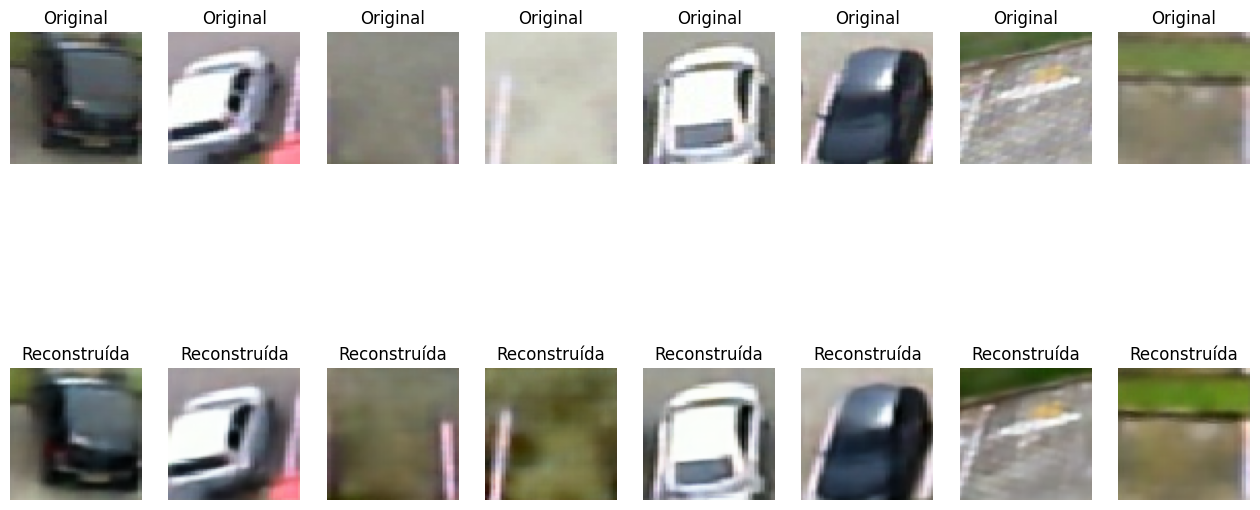

'plot_autoencoder(x_train_UFPR04, autoencoder)\nplot_autoencoder(x_train_UFPR05, autoencoder)'

In [23]:
plot_autoencoder(x_teste, autoencoder)
"""plot_autoencoder(x_train_UFPR04, autoencoder)
plot_autoencoder(x_train_UFPR05, autoencoder)"""

In [24]:
y_teste = teste['classe']
#mapeamento = {'Occupied': 1, 'Empty': 0}

#y_teste_numerico = y_teste.map(mapeamento)

print(y_teste)

6252    1
4684    1
1731    0
4742    0
4521    1
       ..
6412    0
8285    0
7853    1
1095    0
6929    0
Name: classe, Length: 2000, dtype: int64


In [25]:
shape_imagem_codificada = imagens_codificadas.reshape((imagens_codificadas.shape[0], -1))

In [26]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization


classificador = Sequential([
    Dense(128, activation='relu', input_shape=(2048,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
classificador.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = classificador.fit(shape_imagem_codificada, y_teste, epochs=20, batch_size=16, validation_split=0.15)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4934 - loss: 0.8377 - val_accuracy: 0.5067 - val_loss: 0.7735
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5813 - loss: 0.6788 - val_accuracy: 0.5500 - val_loss: 0.7265
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5989 - loss: 0.6670 - val_accuracy: 0.5100 - val_loss: 0.7773
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 0.6691 - val_accuracy: 0.5233 - val_loss: 0.7734
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6023 - loss: 0.6481 - val_accuracy: 0.5100 - val_loss: 0.8237
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 0.6318 - val_accuracy: 0.4733 - val_loss: 0.7804
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6466 - loss: 0.6037 - val_accuracy: 0.5100 - val_loss: 0.7698
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6779 - loss: 0.5811 - val_accuracy: 0

<Axes: >

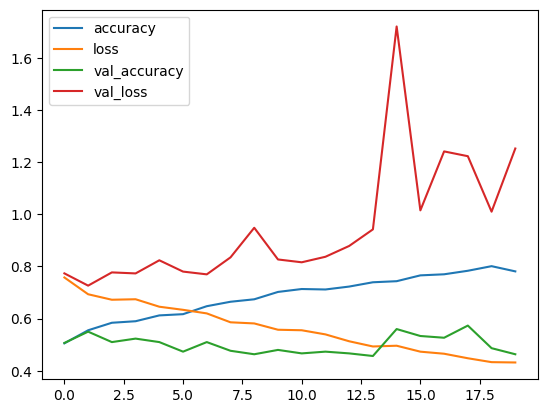

In [30]:
pd.DataFrame(history.history).plot()

In [31]:
"""classificador.save("Modelos_keras/classificador.h5")
classificador.save_weights("weights_finais/classificador.weights.h5")"""

'classificador.save("Modelos_keras/classificador.h5")\nclassificador.save_weights("weights_finais/classificador.weights.h5")'

Found 10000 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 1/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 2/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Processado lote 3/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 4/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 5/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 6/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Processado lote 7/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processado lote 8/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processado lote 9/313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Pro

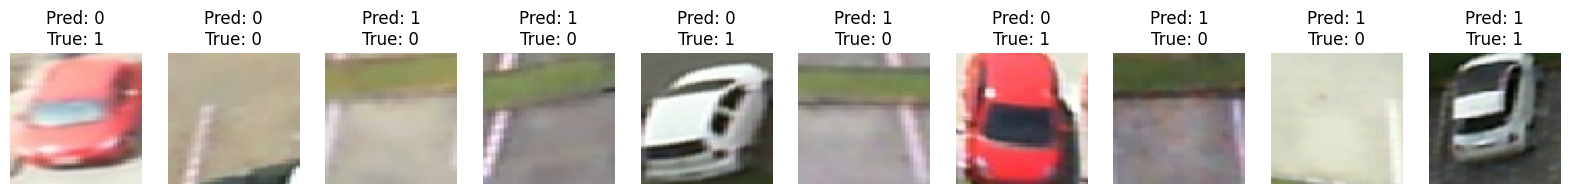

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got '[0 0 1 ... 1 1 1]' instead.

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from visualizacao import plot_confusion_matrix

def plot_predictions(images, predictions, true_labels, save_path:str, class_names, num=10):
    plt.figure(figsize=(20, 20))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        
        pred_class = predictions[i]
        true_class = true_labels[i]
        
        plt.title(f'Pred: {pred_class}\nTrue: {true_class}')
        plt.axis('off')
    plt.savefig(save_path)
    plt.show()

def carregar_e_preprocessar_imagens_em_lotes(caminho_imagens, tamanho=(64, 64), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': caminho_imagens}),
        directory=None,
        x_col='filename',
        target_size=tamanho,
        class_mode=None,
        batch_size=batch_size,
        shuffle=False
    )
    return generator

def carregar_e_preprocessar_imagens(caminho_imagens, tamanho=(64, 64)):
    imagens = []
    for caminho in caminho_imagens:
        img = load_img(caminho, target_size=tamanho)
        img_array = img_to_array(img) / 255.0
        imagens.append(img_array)
    return np.array(imagens)

def predizer_classes(classificador, encoder, caminho:str, batch_size=32):
    nome_arquivo = os.path.basename(caminho)
    nome = os.path.splitext(nome_arquivo)[0].split('_')[1]

    dataframe = pd.read_csv(caminho)

    dataframe['classe'] = dataframe['classe'].astype(str)
    y_dados = dataframe['classe']
    
    x_dados = dataframe['caminho_imagem']

    generator = carregar_e_preprocessar_imagens_em_lotes(x_dados, batch_size=batch_size)

    predicao_classes = []
    for i in range(len(generator)):
        batch = next(generator)
        imagem_codificada = encoder.predict(batch)

        flatten_imgs = imagem_codificada.reshape((imagem_codificada.shape[0], -1))

        predicao = classificador.predict(flatten_imgs)
        predicao_classes.extend(predicao.argmax(axis=1))
        
        print(f"Processado lote {i+1}/{len(generator)}")

    predicao_classes = np.array(predicao_classes)

    # Convert numeric predictions to string labels
    class_names = ['Empty', 'Occupied']
    predicao_classes_str = [class_names[p] for p in predicao_classes]

    # Plot only the first 10 images for visualization
    plot_predictions(
        carregar_e_preprocessar_imagens(x_dados[:10]), 
        predicao_classes[:10], 
        y_dados[:10], 
        f"Resultados/Predicoes/Autoencoder_{nome}", 
        class_names
    )
    
    plot_confusion_matrix(
        y_dados, 
        int(predicao_classes), 
        class_names, 
        f"Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_{nome}", 
        f"Autoencoder {nome}"
    )

predizer_classes(classificador, encoder, 'Datasets_csv/df_PUC.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR04.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR05.csv')

In [ ]:
"""def preprocessamento_completo(caminho: str):

    nome_arquivo = os.path.basename(caminho)

    # Removendo a extensão e pegando a parte desejada
    nome_parte = os.path.splitext(nome_arquivo)[0].split('_')[1]

    dataframe = pd.read_csv(caminho)
    
    dataframe['classe'] = dataframe['classe'].astype(str)

    img_width, img_height = 256, 256
    batch_size = 32

    def normalize_image(img):
        return img / 255.0

    datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    gerador = datagen.flow_from_dataframe( 
        dataframe=dataframe,
        x_col='caminho_imagem',
        y_col='classe',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False  # Não embaralhar para garantir a ordem dos dados
    )

    def extrair_dados(gerador):
        x = []
        y = []
        for img_batch, label_batch in gerador:
            x.append(img_batch)
            y.append(label_batch)
            if len(x) * gerador.batch_size >= gerador.samples:
                break
        return np.concatenate(x), np.concatenate(y)

    x_dados, y_dados = extrair_dados(gerador)

    return nome_parte, x_dados, y_dados

"""

In [ ]:
"""def carregar_e_preprocessar_imagens(caminho_imagens, tamanho=(64, 64)):
    imagens = []
    for caminho in caminho_imagens:
        img = load_img(caminho, target_size=tamanho)
        img_array = img_to_array(img) / 255.0
        imagens.append(img_array)
    return np.array(imagens)"""

In [ ]:
"""import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from visualizacao import plot_confusion_matrix

def carregar_e_preprocessar_imagens(caminho_imagens, tamanho=(64, 64)):
    imagens = []
    for caminho in caminho_imagens:
        img = load_img(caminho, target_size=tamanho)
        img_array = img_to_array(img) / 255.0  # Normalizar para intervalo [0,1]
        imagens.append(img_array)
    return np.array(imagens)

def predizer_classes(classificador, encoder, caminho:str):
    nome_arquivo = os.path.basename(caminho)
    nome = os.path.splitext(nome_arquivo)[0].split('_')[1]

    dataframe = pd.read_csv(caminho)
    dataframe['classe'] = dataframe['classe'].astype(str)
    y_dados = dataframe['classe']
    class_mapping = {'Empty': 0, 'Occupied': 1}

    y_num = y_dados.map(class_mapping)

    x_dados = dataframe['caminho_imagem']

    imagens = carregar_e_preprocessar_imagens(x_dados)
    
    imagem_codificada = encoder.predict(imagens)
    flatten_imgs = imagem_codificada.reshape((imagem_codificada.shape[0], -1))

    predicao = classificador.predict(flatten_imgs)
    predicao_classes = predicao.argmax(axis=1)

    # Passar as imagens reais para plotar as previsões
    plot_predictions(imagens[:10], predicao_classes[:10], y_dados[:10], f"Resultados/Predicoes/Autoencoder_{nome}", class_names=['Empty', 'Occupied'])
    plot_confusion_matrix(y_num, predicao_classes, ['Empty', 'Occupied'], f"Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_{nome}", f"Autoencoder {nome}")

predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR04.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR05.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_PUC.csv')"""
